<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw13/Homework13_realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [2]:
from dul_2021.utils.hw13_utils import *

In [3]:
from tqdm.notebook import tqdm

In [4]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

from tqdm import trange

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



In [6]:
class conv2d_weighted(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
      super().__init__(in_channels, out_channels, kernel_size, stride=1, padding=0)
      self.weighted_conv2d = nn.utils.weight_norm(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
      
  def forward(self, x):
      output = self.weighted_conv2d(x)
      return output

In [7]:
class ResnetBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.block = nn.Sequential(conv2d_weighted(128, 128, (1, 1), 1, 0),
                               nn.ReLU(),
                               conv2d_weighted(128, 128, (3, 3), 1, 1),
                               nn.ReLU(),
                               conv2d_weighted(128, 128, (1, 1), 1, 0))
  def forward(self, x):
    return x + self.block(x)

In [8]:
class SimpleResnet(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.resblock = ResnetBlock()
    self.model = nn.Sequential(conv2d_weighted(n_channels, 128, (3, 3), 1, 1),
                               self.resblock, 
                               self.resblock, 
                               self.resblock, 
                               self.resblock,
                               nn.ReLU(),
                               conv2d_weighted(128, n_channels * 2, (3, 3), 1, 1))

  def forward(self, x):
    return self.model(x)

In [9]:
class ActNorm(nn.Module):
    def __init__(self, n_channels: int):
        super(ActNorm, self).__init__()
        self.n_channels = n_channels
        self.log_s = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.t = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.initialized = False

    def _initialize_weights(self, x):
        self.t.data = -torch.mean(x, dim=(0, 2, 3), keepdim=True)
        _x = x.permute(1, 0, 2, 3).reshape(self.n_channels, -1)
        self.log_s.data = -torch.log(torch.std(_x, dim=1).reshape(1, self.n_channels, 1, 1))

    def forward(self, x, inference=False):
        if inference:
            return (x - self.t) * torch.exp(-self.log_s), self.log_s
        if not self.initialized:
            self._initialize_weights(x)
        # print(x.shape, self.log_s.exp().shape, self.t.shape)
        output = x * self.log_s.exp() + self.t
        return output, self.log_s

In [10]:
class AffineCouplingWithCheckerboard(nn.Module):
  def __init__(self, start_idx: int):
    super(AffineCouplingWithCheckerboard, self).__init__()
    self.start_idx = start_idx
    self.mask = self._get_mask()
    self.g = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.b = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.net = SimpleResnet(n_channels=3)
  
  def _get_mask(self, matrix_size: int = 32):
    mask = torch.arange(32).reshape(-1, 1) + torch.arange(32)
    mask %= 2
    mask = mask.view(1, 1, matrix_size, matrix_size).to(device)
    return mask

  def forward(self, x, inference: bool = False):
      mask = self.mask.repeat(x.shape[0], 1, 1, 1).to(device)
      x_checkerboard = x * mask
      log_s, t = self.net(x_checkerboard).split(x.shape[1], dim=1)
      log_s = self.g * torch.tanh(log_s) + self.b

      mask_inverse = 1 - mask
      t_ = t * mask_inverse
      log_s_ = log_s * mask_inverse

      if inference:
          z = ((x - t_)) * torch.exp(-log_s_)
          return z, log_s_

      z = x * torch.exp(log_s_) + t_
      return z, log_s_

In [11]:
# x = torch.rand((128, 3, 32, 32))
# x.shape
# mask = torch.arange(32).reshape(-1, 1) + torch.arange(32)
# mask %= 2
# mask = mask.view(-1, 1, 32, 32)
# mask.repeat(128, 1, 1, 1).shape
# (mask * x).shape

In [12]:
checkerboard_transforms_block_large = nn.ModuleList([AffineCouplingWithCheckerboard(1),
                                                    ActNorm(3),
                                                    AffineCouplingWithCheckerboard(0),
                                                    ActNorm(3),
                                                    AffineCouplingWithCheckerboard(1),
                                                    ActNorm(3),
                                                    AffineCouplingWithCheckerboard(0)])

In [13]:
# x = torch.rand((64, 3, 32, 32)).float().to(device)
# for t in checkerboard_transforms_block_large:
#     t.to(device)
#     x = t(x)[0]
#     print(x.shape)

In [14]:
checkerboard_transforms_block_small = nn.ModuleList([AffineCouplingWithCheckerboard(1),
                                                    ActNorm(3),
                                                    AffineCouplingWithCheckerboard(0),
                                                    ActNorm(3),
                                                    AffineCouplingWithCheckerboard(1)])

In [15]:
class AffineCouplingWithChannels(nn.Module):
  def __init__(self, white_first: bool = True):
    super(AffineCouplingWithChannels, self).__init__()
    self.white_first = white_first
    self.mask = self._get_mask()
    self.g = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.b = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.net = SimpleResnet(n_channels=6)
  
  def _get_mask(self, matrix_size: int = 32):
    mask = []
    for i in range(matrix_size):
      if i % 2 == 0:
        mask.append([1, 0] * (matrix_size // 2))
      else:
        mask.append([0, 1] * (matrix_size // 2))
    mask = torch.tensor(mask, dtype=torch.float).view(-1, 1, matrix_size, matrix_size)
    return mask

  def forward(self, x, inference: bool = False):
        black, white = x.split(x.shape[1] // 2, dim=1)

        if self.white_first:
          white, black = black, white

        log_s, t = self.net(black).split(x.shape[1] // 2, dim=1)
        log_s = self.g * torch.tanh(log_s) + self.b

        if inference:
            _white = (white - t) * torch.exp(-log_s)

        else:
            _white = white * log_s.exp() + t

        if self.white_first:
          return (torch.cat([_white, black], dim=1), 
                  torch.cat([log_s, torch.zeros_like(log_s)], dim=1))
        else:
          return (torch.cat([black, _white], dim=1), 
                  torch.cat([torch.zeros_like(log_s), log_s], dim=1))

In [16]:
# x = torch.rand([64, 12, 16, 16]).float().to(device)
# for t in channel_transforms_block:
#   t.to(device)
#   x = t(x)[0]
#   print(x.shape)

In [17]:
channel_transforms_block = nn.ModuleList([AffineCouplingWithChannels(True),
                                         ActNorm(12),
                                         AffineCouplingWithChannels(False),
                                         ActNorm(12),
                                         AffineCouplingWithChannels(True)])

In [18]:
class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()
        self.checkerboard_transforms_block_large = checkerboard_transforms_block_large
        self.checkerboard_transforms_block_small = checkerboard_transforms_block_small
        self.channel_transforms_block = channel_transforms_block

    @staticmethod
    def squeeze(x):
        batch_size, n_channels, img_size = x.shape[:3]
        x = x.reshape(batch_size, n_channels, img_size // 2, 2, img_size // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(batch_size, n_channels * 4, img_size // 2, img_size // 2)
        return x

    @staticmethod
    def unsqueeze(x):
        batch_size, n_channels, img_size = x.shape[:3]
        x = x.reshape(batch_size, n_channels // 4, 2, 2, img_size, img_size)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(batch_size, n_channels // 4, img_size * 2, img_size * 2)
        return x


    def forward(self, x):
        log_det = torch.zeros_like(x)
        # print(x.shape)

        for transform in self.checkerboard_transforms_block_large:
          x, det = transform(x)
          log_det += det
        
        x = self.squeeze(x)
        log_det = self.squeeze(log_det)

        # print(x.shape)

        for transform in self.channel_transforms_block:
          x, det = transform(x)
          # print(x.shape)
          log_det += det
        
        x = self.unsqueeze(x)
        log_det = self.unsqueeze(log_det)

        for transform in self.checkerboard_transforms_block_small:
          x, det = transform(x)
          log_det += det

        return x, log_det


    def generate(self, noise):
        for transform in self.checkerboard_transforms_block_small:
          noise = transform(noise, inference=True)[0]
        noise = self.squeeze(noise)
        
        for transform in self.channel_transforms_block:
          noise = transform(noise, inference=True)[0]
        noise = self.unsqueeze(noise)
        
        for transform in self.checkerboard_transforms_block_large:
          image = transform(noise, inference=True)[0]
        return image

In [19]:
class Trainer:
    def __init__(self, model):
        self.eps = 1e-5
        self.verbose = 1
        self.epochs = 3
        self.lr = 1e-4
        self.alpha = 5e-2
        self.real_nvp = model.to(device)
        self.distribution = Normal(torch.tensor([0.0], device=device), torch.tensor([1.0], device=device))
        self.optimizer = torch.optim.AdamW(self.real_nvp.parameters(), lr=self.lr)


    def logit_trick(self, x):
        x = (x + Uniform(0, 0.1).sample(x.shape).to(device)).clamp(0, 1)
        x = x * (1 - self.alpha) + self.alpha
        logits = torch.log(x + self.eps) - torch.log(1 - x + self.eps) + np.log(1 - self.alpha)
        log_det = (F.softplus(logits) + F.softplus(-logits)).sum(dim=(1, 2, 3))
        return logits, log_det


    def log_prob(self, logits):
        z, log_det = self.real_nvp(logits)
        p_x = log_det.sum(dim=(1, 2, 3))
        p_z = self.distribution.log_prob(z).sum(dim=(1, 2, 3))
        return p_x + p_z


    def compute_loss(self, x):
        logits, log_det = self.logit_trick(x)
        log_prob = (self.log_prob(logits) + log_det).mean()
        return -log_prob / 3072


    def evaluate(self, test_loader):
        self.real_nvp.eval()
        val_losses = []
        with torch.no_grad():
          for x in test_loader:
              x = x.permute(0, 3, 1, 2)
              x = x.to(device)
              val_loss = self.compute_loss(x)
              val_losses.append(val_loss.item())
        return np.mean(val_losses)


    def fit(self, train_loader, test_loader):
        train_losses, test_losses = [], []
        self.real_nvp.train()

        for epoch in trange(self.epochs):
            for x in train_loader:
                x = x.permute(0, 3, 1, 2)
                x = x.to(device)
                loss = self.compute_loss(x)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_losses.append(loss.item())
            if epoch % self.verbose == 0:
                test_loss = self.evaluate(test_loader)
                test_losses.append(test_loss)
        samples = self.sample()
        interpolations = self.interpolate(test_loader)
        return train_losses, test_losses, samples, interpolations


    def sample2img(self, x):
        with torch.no_grad():
            x = 1 / (1 + torch.exp(-x))
            x = x - self.alpha
            x = x / (1 - self.alpha)
            x = x.permute(0, 2, 3, 1).clamp(0, 1)
            return x.cpu().numpy()

    def sample(self, n=100):
        self.real_nvp.eval()
        with torch.no_grad():
            noise = self.distribution.sample((n, 3, 32, 32))
            return self.sample2img(self.real_nvp.generate(noise.squeeze(-1)))

    def interpolate(self, test_loader, n_images=10):
        for i, x in enumerate(test_loader):
            x = x.permute(0, 3, 1, 2)
            images = x[:n_images, :, :, :]
            if i == 0:
                break
        
        self.real_nvp.eval()
        latents = []

        with torch.no_grad():
            images = images.float().to(device)
            logits = self.logit_trick(images)[0]
            noise = self.real_nvp(logits)[0]

            for i in range(n_images // 2):
                first_part = noise[i].unsqueeze(0)
                last_part = noise[n_images // 2 + i].unsqueeze(0)
                d = (last_part - first_part) / (n_images // 2)
                latents.append(first_part)

                for j in range(1, n_images // 2):
                    latents.append(first_part + d * j)
                latents.append(last_part)

            latents = torch.cat(latents)
            res = self.real_nvp.generate(latents)
            return self.sample2img(res)

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

  train_loader = torch.utils.data.DataLoader((train_data / 3).astype(np.float32), batch_size=128, shuffle=True, pin_memory=True)
  test_loader = torch.utils.data.DataLoader((test_data / 3).astype(np.float32), batch_size=128, shuffle=False, pin_memory=True)

  model = Trainer(RealNVP())
  train_losses, test_losses, samples, interpolations = model.fit(train_loader, test_loader)
  return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



100%|██████████| 2/2 [31:47<00:00, 953.75s/it]


Final Test Loss: -1.8116


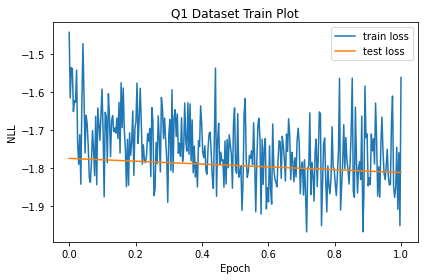

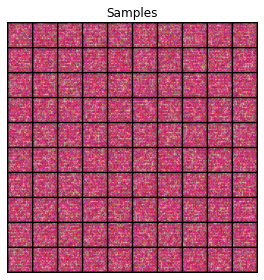

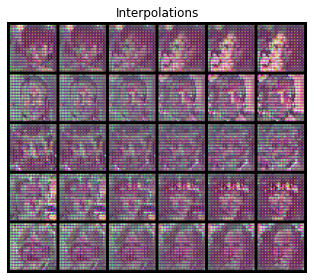

In [ ]:
q1_save_results(q1_a, 'a')

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [20]:
class AffineBadMasking(nn.Module):
  def __init__(self):
    super(AffineBadMasking, self).__init__()
    self.mask = self._get_mask()
    self.g = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.b = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.net = SimpleResnet(n_channels=3)

  def _get_mask(self):
    mask = torch.ones((1, 1, 32, 32)).float().to(device)
    mask[:, :, :, :16] = 0
    return mask

  def forward(self, x, inference=False):
    mask = self.mask.repeat(x.shape[0], 1, 1, 1)
    log_s, t = self.net(x * mask).chunk(2, dim=1)
    log_s = self.g * torch.tanh(log_s) + self.b
    t = (1.0 - mask) * t
    log_s = (1.0 - mask) * log_s
    if inference:
        x = (x - t) * torch.exp(-log_s)
    else:
        x = x * torch.exp(log_s) + t
    return x, log_s

In [22]:
bad_masking_transforms_block = nn.ModuleList([AffineBadMasking(), 
                                              ActNorm(3),
                                              AffineCouplingWithCheckerboard(1),
                                              AffineBadMasking(), 
                                              ActNorm(3),
                                              AffineCouplingWithCheckerboard(1),
                                              AffineBadMasking(), 
                                              ActNorm(3),
                                              AffineCouplingWithCheckerboard(1),
                                              AffineBadMasking(), 
                                              ActNorm(3),
                                              AffineCouplingWithCheckerboard(1)])

In [23]:
class BadMaskingNVP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bad_masking_transforms = bad_masking_transforms_block


    def forward(self, x):
        log_det = torch.zeros_like(x)

        for transform in self.bad_masking_transforms:
          x, det = transform(x)
          log_det += det

        return x, log_det


    def generate(self, noise):
        for transform in self.bad_masking_transforms:
          noise = transform(noise, inference=True)[0]
        return noise

### Solution

In [24]:
def q1_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

  train_loader = torch.utils.data.DataLoader((train_data / 3).astype(np.float32), batch_size=128, shuffle=True, pin_memory=True)
  test_loader = torch.utils.data.DataLoader((test_data / 3).astype(np.float32), batch_size=128, shuffle=False, pin_memory=True)
  model = Trainer(BadMaskingNVP())
  train_losses, test_losses, samples, interpolations = model.fit(train_loader, test_loader)
  return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



100%|██████████| 3/3 [42:06<00:00, 842.32s/it]


Final Test Loss: -1.1091


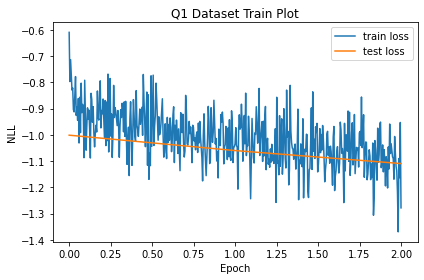

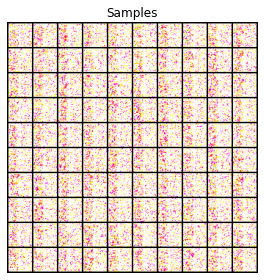

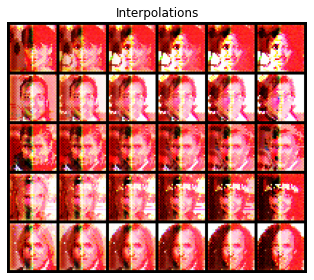

In [25]:
q1_save_results(q1_b, 'b')

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b1, 'bonus1')

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b2, 'bonus2')